# Librerie e dipendenze

Importazione delle librerie necessarie ed inizializzazione dell'oggetto SparkSession, il quale consente di configurare un'applicazione Spark.

In [ ]:
# Install PySpark's dependecies
!pip install pyspark

import pandas as pd
import numpy as np
import itertools as it
import timeit
import matplotlib.pyplot as plt

from google.colab import drive
from collections import Counter
from pyspark import SparkContext
from pyspark.sql import SparkSession

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Start SparkSession
spark = SparkSession.builder.appName("Big_Data_Project").getOrCreate()

# Start SparkContext
sc = spark.sparkContext

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset


Il dataset utilizzato è **online_retail_II**, un vero e proprio dataset che contiene tutte le transazioni che si verificano per un rivenditore online con sede nel Regno Unito tra il 01/12/2009 e il 09/12/2011. 

Il dataset è composto da otto colonne: 

- **Invoice**: Numero di 6 cifre assegnato in modo univoco a ciascuna transazione. Se questo codice inizia con la lettera "c", indica una cancellazione. 

- **StockCode**: Numero di 5 cifre assegnato in modo univoco a ciascun prodotto distinto. 

- **Description**: Nome del prodotto. 

- **Quantity**: Le quantità di ciascun prodotto (articolo) per transazione. 

- **InvoiceDate**: Data e ora in cui è stata generata una transazione. 

- **UnitPrice**: Prezzo unitario del prodotto. 

- **Customer ID**: Numero di 5 cifre assegnato in modo univoco a ciascun cliente. 

- **Country**: Paese in cui risiede un cliente. 

Per ulteriori informazioni, e per scaricare il dataset, consultare il link sottostante, 

[UCI Machine Learning Repository: Online Retail II Data Set ](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II)

Nella sezione **Dataset > Preparazione** il dataframe viene rielaborato così che ogni riga rappresenti una transazione, nelle colonne avremo invece gli item.

Creiamo 3 liste di transazioni per confrontare gli algoritmi al crescere delle transazioni:
1. transactions_small: 
    - Numero transazioni: **2101**
    - Massimo numero di items nelle transazioni: **200**
2. transactions_medium
    - Numero transazioni: **23660**
    - Massimo numero di items nelle transazioni: **674**
3. transactions_big
    - Numero transazioni: **25761**
    - Massimo numero di items nelle transazioni: **674**

## Caricamento

In [ ]:
# Path of Dataset
path = "drive/MyDrive/BigData/Progetto/Dataset/"

# Load Dataset
df = pd.read_excel(path + 'online_retail_II.xlsx')

print("Shape of Dataset:", df.shape)
df.head(2)

Shape of Dataset: (525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


## Esplorazione

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [ ]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [ ]:
df['Country'].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland'], dtype=object)

## Preparazione

In [ ]:
# Remove null value for description column
print(df.shape)
df.dropna(subset=['Description'], inplace=True)

df.shape

(525461, 8)


(522533, 8)

In [ ]:
# Convert int value to string value
df['Invoice']   = df['Invoice'].astype('str')
df['Description'] = df['Description'].astype('str')

# Remove rows with 'POSTAGE' value for column 'Description'
df = df.loc[df['Description'] != 'POSTAGE']



> transactions_small



In [ ]:
# Filter dataset by country
country = 'United Kingdom'
df_country_small = df.loc[df['Country'] != country]

# Each row is a transaction & each column is an item
basket_small = df_country_small.groupby(['Invoice','Description'])['Description'].sum().unstack().fillna(False)
print("Shape of Basket:", basket_small.shape)
basket_small.head(2)

Shape of Basket: (2101, 3203)


Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,CHERRY BLOSSOM DECORATIVE FLASK,FLAMINGO LIGHTS,HOME SWEET HOME BLACKBOARD,IVORY PAPER CUP CAKE CASES,LARGE SKULL WINDMILL,NEW BAROQUE BLACK BOXES,PAINT YOUR OWN CANVAS SET,...,ZINC HEART HANGER WITH HOOKS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE DOUBLE PLANTER,ZINC HEART LATTICE PLANTER BOWL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC POLICE BOX LANTERN,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,
489439,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489450,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Make list of transactions
transactions_small = basket_small.values.tolist()
transactions_small = [[item for item in row if item != False] for row in transactions_small]
max_len_itemsets = len(max(transactions_small, key=len))
# Make flattened itemset dataset
flat_items_small = list(it.chain(*transactions_small))

print("Example of transaction:", transactions_small[0])
print("Number of transactions:", len(transactions_small))
print("Max length of itemsets:", max_len_itemsets)

Example of transaction: [' VINTAGE DESIGN GIFT TAGS', 'ASSORTED CAKES FRIDGE MAGNETS', 'ASSORTED COLOUR MINI CASES', 'BAKING SET 9 PIECE RETROSPOT ', 'BLACK/BLUE DOTS RUFFLED UMBRELLA', 'CHRISTMAS PUDDING TRINKET POT ', 'LUNCHBOX WITH CUTLERY RETROSPOT ', 'PACK 20 DOLLY PEGS', 'PARTY CONE CHRISTMAS DECORATION ', 'PINK DOUGHNUT TRINKET POT ', 'RED TOADSTOOL LED NIGHT LIGHT', 'RED/WHITE DOTS RUFFLED UMBRELLA', 'RETRO SPORT PARTY BAG + STICKER SET', 'RETRO SPOT TEA SET CERAMIC 11 PC ', 'SET OF THREE VINTAGE GIFT WRAPS', 'SET/3 RUSSIAN DOLL STACKING TINS', 'WRAP BLUE RUSSIAN FOLKART', 'WRAP ENGLISH ROSE ']
Number of transactions: 2101
Max length of itemsets: 200




> transactions_medium



In [ ]:
# Filter dataset by country
country = 'United Kingdom'
df_country_medium = df.loc[df['Country'] == country]

# Each row is a transaction & each column is an item
basket_medium = df_country_medium.groupby(['Invoice','Description'])['Description'].sum().unstack().fillna(False)
print("Shape of Basket:", basket_medium.shape)
basket_medium.head(2)

Shape of Basket: (23660, 4656)


Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,FAIRY CAKE CANDLES,...,wet & rotting,wet and rotting,wet cartons,wet ctn,wet damages,wet/smashed/unsellable,wonky bottom/broken,wrong code,wrong ctn size,wrong invc
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Make list of transactions
transactions_medium = basket_medium.values.tolist()
transactions_medium = [[item for item in row if item != False] for row in transactions_medium]
max_len_itemsets = len(max(transactions_medium, key=len))
# Make flattened itemset dataset
flat_items_medium = list(it.chain(*transactions_medium))

print("Example of transaction:", transactions_medium[0])
print("Number of transactions:", len(transactions_medium))
print("Max length of itemsets:", max_len_itemsets)

Example of transaction: [' WHITE CHERRY LIGHTS', '15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'FANCY FONT HOME SWEET HOME DOORMAT', 'PINK CHERRY LIGHTS', 'PINK DOUGHNUT TRINKET POT ', 'RECORD FRAME 7" SINGLE SIZE ', 'SAVE THE PLANET MUG', 'STRAWBERRY CERAMIC TRINKET BOX']
Number of transactions: 23660
Max length of itemsets: 674




> transactions_big



In [ ]:
# Each row is a transaction & each column is an item
basket_big = df.groupby(['Invoice','Description'])['Description'].sum().unstack().fillna(False)
print("Shape of Basket:", basket_big.shape)
basket_big.head(2)

Shape of Basket: (25761, 4680)


Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,FAIRY CAKE CANDLES,...,wet & rotting,wet and rotting,wet cartons,wet ctn,wet damages,wet/smashed/unsellable,wonky bottom/broken,wrong code,wrong ctn size,wrong invc
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:

# Make list of transactions
transactions_big = basket_big.values.tolist()
transactions_big = [[item for item in row if item != False] for row in transactions_big]
max_len_itemsets = len(max(transactions_big, key=len))
# Make flattened itemset dataset
flat_items_big = list(it.chain(*transactions_big))

print("Example of transaction:", transactions_big[0])
print("Number of transactions:", len(transactions_big))
print("Max length of itemsets:", max_len_itemsets)

Example of transaction: [' WHITE CHERRY LIGHTS', '15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'FANCY FONT HOME SWEET HOME DOORMAT', 'PINK CHERRY LIGHTS', 'PINK DOUGHNUT TRINKET POT ', 'RECORD FRAME 7" SINGLE SIZE ', 'SAVE THE PLANET MUG', 'STRAWBERRY CERAMIC TRINKET BOX']
Number of transactions: 25761
Max length of itemsets: 674


# HashTree


La classe HashTree implementa la struttura dati HashTree in cui ogni nodo dell’albero rappresenta un hash univoco dei suoi figli. 

> La classe ha un **costruttore** che inizializza l'albero con:

*  Proprietà hash che rappresenta l'hash del nodo
*  Lista children che contiene i figli del nodo.

> La classe ha un metodo **insert** che consente di inserire un nuovo nodo nell'albero di hash:
 
*  Se il dato inserito è una tupla, viene aggiunto alla lista dei figli del nodo corrente.
*  Se il dato inserito è una lista, viene creato un nuovo nodo figlio per ogni elemento della lista e viene calcolato l'hash di ciascun figlio. 

L'hash del nodo corrente viene calcolato utilizzando la funzione di hash *SHA-256*. 

> La classe ha anche un metodo **get_all_tuples** che restituisce una lista di tutte le tuple (foglie) presenti nell'albero di hash. Il metodo attraversa ricorsivamente l'albero e raccoglie tutti i dati nelle foglie.

In [ ]:
import hashlib

# Implement HashTree data structure for yafim algorithm
class HashTree:

    # Init HashTree
    def __init__(self):
        self.hash = None
        self.children = []

    # Insert a new node in HashTree
    def insert(self, data):
        # tuple
        if isinstance(data, tuple):
            self.children.append(data)
        # list of tuples
        else:
            child_hashes = []
            for d in data:
                child = HashTree()
                child.insert(d)
                child_hashes.append(child.hash)
                self.children.append(child)
            # Apply hash function for encode data
            self.hash = hashlib.sha256(str(data).encode()).hexdigest()

    # Get all tuples stored in HashTree    
    def get_all_tuples(self):
        tuples = []
        for child in self.children:
            if isinstance(child, HashTree):
                tuples.extend(child.get_all_tuples())
            else:
                tuples.append(child)
        return tuples

# Algoritmi

## Apriori

L'algoritmo apriori viene richiamato all'interno dell'algoritmo di SON,
apriori prende in input tre argomenti:

*  Lista di transazioni
*  Soglia di supporto
*  Dimensione dell'intero dataset

La funzione inizia calcolando il supporto per il chunk considerato, calcolato come il prodotto tra la soglia di supporto e la percentuale di transazioni in questo chunk rispetto all'intero insieme di transazioni.

```
# Size of chunk
size_chunk = len(chunk)
# Support for this chunk
chunk_sup  = support * (size_chunk / size_basket)
```
Successivamente, viene calcolata la frequenza di ogni singolo elemento nella lista di items *flat_items* utilizzando la classe **Counter** di Python. Selezioniamo gli elementi che soddisfano il supporto minimo richiesto, e memorizziamoli in una lista in cui andremo a memorizzare i frequent itemset trovati nel chunk. 

Una volta trovati i frequent itemset di lunghezza 1, da questi generiamo frequent itemset di lunghezza 2, e così via, fin quando non sono più generati itemset di candidati. 

Durante la generazione degli itemset candidati, viene utilizzata la funzione **c_frequency** per calcolare la frequenza degli itemset candidati. 

Eseguiamo una fase di pruning per selezionare solo gli itemset che soddisfano la soglia di supporto.

Infine, la funzione apriori restituisce una lista di tuple, dove in ogni tupla vi è un frequent itemset per il chunk considerato. 

In [ ]:
def c_frequency(candidate, chunk, option):
  # Initialize dictionary for store candidate items
  candidate_freq = {}
  for itemset in candidate:
      candidate_freq[itemset] = 0

  # Count frequency of each itemset in the dataset
  for transaction in chunk:
      for itemset in candidate:
          if set(itemset).issubset(set(transaction)):
              candidate_freq[itemset] += 1
  
  # Check if the algorithm has been called by 'apriori' or 'son'
  if option == "apriori":
      candidate_freq = {k: round(v / len(chunk), 3) for k, v in candidate_freq.items()}
      
  return list(candidate_freq.items())

def apriori(chunk, support, size_basket):
  # Size of chunk
  size_chunk = len(chunk)

  # Support for this chunk
  chunk_sup  = support * (size_chunk / size_basket)
  
  # Get flattened itemsets in basket
  flat_items = list(it.chain.from_iterable(chunk))
  
  # Calculate frequency for each items
  frequency  = Counter(flat_items)
  
  # Select items with support >= 'chunk_sup'
  candidate  = [(x,) for x in frequency.keys() if round(frequency[x] / size_chunk, 3) >= chunk_sup]
  flat_items = list(it.chain.from_iterable(candidate))

  # Initialize list for store frequent itemsets
  frequent_it = []
  frequent_it = frequent_it + candidate

  while len(candidate) != 0:
    # From candidate of length k generate candidate of length (k+1)
    candidate = [(i,*j) for i in flat_items for j in candidate if (i not in j)]

    # Filter out duplicate tuple
    candidate = [tuple(sorted(arr)) for arr in candidate]
    candidate = list(set(candidate))

    # Calculate support for each itemset
    candidate = c_frequency(candidate, chunk, "apriori")

    # Select itemsets with support >= 'chunk_sup'
    candidate = [x[0] for x in candidate if x[1] >= chunk_sup]

    # Store frequent itemsets of length (k+1)
    frequent_it = frequent_it + candidate
  
  ### Return list of tuples: [(itemset I), ...]
  return frequent_it

## SON (Savasere, Omiecinski e Navathe)

L’algoritmo prende due argomenti in input: 

*  Lista di transazioni
*  Soglia di supporto

L'algoritmo prevede due fasi: 

> **Prima Fase:**

Il dataset viene suddiviso in chunk, ad ogni chunk viene applicato l'algoritmo **Apriori** tramite la funzione **mapPartitions()**, una trasformazione narrow che applica una funzione a ciascuna partizione dell'RDD.
Terminata l’applicazione di Apriori, attraverso una fase di MapReduce selezioniamo gli itemset candidati che compaiono almeno una volta nel dataset. 

> **Seconda Fase:**

Nella seconda fase dell’algoritmo, calcoliamo la frequenza di ogni itemset candidato in ogni chunk utilizzando la funzione **c_frequency**, che restituisce il numero di volte in cui ogni itemset candidato appare in un dato chunk. Successivamente, in una fase di reduce si raggruppano le frequenze in base agli itemset, da questo otteniamo per ogni itemset la frequenza in cui esso appare nel dataset. Questi risultati sono quindi filtrati per ottenere gli itemset frequenti che superano la soglia di supporto minimo. 

Infine, la funzione restituisce gli itemset frequenti come una lista di tuple in cui il primo elemento è l'itemset e il secondo elemento è il suo supporto. 


> **Calcolo del supporto** viene eseguito tramite una fase di MapReduce, in cui:
1. Nella fase di map per ogni itemset viene prodotta la coppia chiave valore **(itemset, 1)**
2. I reducer raggruppano in base alle chiavi, ovvero gli itemset, e sommano i valori associati a ciascuna chiave, producendo una coppia **(itemset, frequenza dell'itemset)**

In [ ]:
def son(basket_list, sup, num_partitions):
  ### Input: [[transactions T], ...]
  # Create RDD with transactions dataset & set number of chunk
  basket_rdd = sc.parallelize(basket_list, num_partitions).persist()

  # Size of transactional dataset
  size_basket = len(basket_list)
    
  # Apply apriori at each chunk
  candidate_rdd = basket_rdd.mapPartitions(lambda x: apriori(list(x), sup, size_basket))

  # Select items that appear at least once
  candidate_rdd = candidate_rdd.map(lambda item: (item , 1))\
                               .reduceByKey(lambda x,y: x+y)\
                               .filter(lambda item: item[1] >= 1)\
                               .map(lambda x: x[0])
  
  # For each candidate itemsets counts how many times it appears in each chunk
  candidate_list = candidate_rdd.collect()
  candidate_rdd = basket_rdd.mapPartitions(lambda x: c_frequency(candidate_list, list(x), "son"))

  # Select itemsets whose total support is greater than the support threshold
  candidate_rdd = candidate_rdd.reduceByKey(lambda x,y: x+y)\
                               .filter(lambda item: item[1] / size_basket >= sup)
  
  # Remove all blocks for rdd from memory and disk
  basket_rdd.unpersist()
  ### Return list of tuples [((itemset I), support for I), ...]
  return candidate_rdd.collect()

## YAFIM (Yet Another Frequent Itemset Mining)

L’algoritmo prende due argomenti in input:
*   lista delle transazioni
*   soglia di supporto

L'algoritmo prevede due fasi: 

> **Prima Fase:**

Viene calcolata la frequenza di ogni item nel dataset, vengono quindi selezionati solo gli itemset che superano la soglia di supporto. A questo punto viene istanziato un oggetto **HashTree** per memorizzare i frequent itemset. Inizializziamo l'oggetto HashTree con i frequent itemsets di lunghezza 1.

> **Seconda Fase:**

Fin quando sono generati candidati:

1. Generiamo candidati di lunghezza (k+1) tramite il prodotto cartesiano tra frequent itemset di lunghezza k e gli elementi dell’RDD *flat_basket_rdd*. 
2. Per alleggerire il carico eliminiamo dai candidati (k+1) gli itemset che contengono item che non fanno parte dei frequent itemset di lunghezza k.
3. Vengono eliminati gli itemset che presentano duplicati e che non hanno lunghezza (k+1). 
4. Viene generato il prodotto cartesiano tra l’RDD basket_rdd e l’RDD degli elementi candidati per contare l’occorrenza di ciascun candidato nel dataset transazionale. 
5. Viene eseguita una fase di pruning in cui calcoliamo il supporto degli itemset ed eliminiamo gli elementi il cui supporto è inferiore alla soglia impostata. Gli itemset rimanenti vengono inseriti nell'HashTree.

L'algoritmo restituisce in output un HashTree contenente una lista di tuple, dove ogni tupla contiene due elementi: **(Itemset I, Frequenza di I nel dataset)**.

Nell'implementazione usiamo una **variabile broadcast** in quanto può essere memorizzata in cache in modo efficiente su tutti i nodi di un cluster distribuito, la variabile viene trasmessa una volta sola dalla macchina driver ai nodi worker e poi memorizzata in memoria su quei nodi per la durata del task. L'utilizzo di una variabile broadcast per trasmettere i frequent itemset di lunghezza k permette di incrementare le prestazioni dell'algoritmo.

> **Calcolo del supporto** viene eseguito tramite una fase di MapReduce, in cui:
1. Nella fase di map per ogni itemset viene prodotta la coppia chiave valore **(itemset, 1)**
2. I reducer raggruppano in base alle chiavi, ovvero gli itemset, e sommano i valori associati a ciascuna chiave, producendo una coppia **(itemset, frequenza dell'itemset)**

In [ ]:
def yafim(basket_list, sup):
  ### Input: [[transactions T], ...]
  
  # Create RDD with transactions dataset
  basket_rdd = sc.parallelize(basket_list).persist()

  # Create RDD with flatten items
  flat_basket_list = list(it.chain(*basket_list))
  flat_basket_rdd = sc.parallelize(flat_basket_list).persist()
  
  # Size of basket
  size_basket = len(basket_list)
  
  # Calculate support for each item & filter out itemset with support < 'sup'
  candidate_rdd = flat_basket_rdd.map(lambda item: (item , 1))\
                                 .reduceByKey(lambda x,y: x+y)\
                                 .filter(lambda item: item[1] / size_basket >= sup)\
  
  # Create & initialize HashTree with frequent items of length 1
  ht = HashTree()
  ht.insert(candidate_rdd.collect())

  # Broadcast frequent items of length 1
  frequent_items = sc.broadcast(set([item[0] for item in candidate_rdd.collect()]))

  # From frequent itemsets of length k generate frequent itemsets of length (k+1)
  k = 1
  while(candidate_rdd.isEmpty() == False):

    # 1. Generate the Cartesian product between frequent itemsets generates at step k and items in flattened basket
    candidate_rdd = candidate_rdd.map(lambda x: x[0])\
                                 .cartesian(flat_basket_rdd.distinct())                             
    if k > 1:
      candidate_rdd = candidate_rdd.filter(lambda x: x[1] not in x[0])\
                                   .map(lambda x: (*x[0], x[1]))
    
    # 2. Filter out candidate itemsets that contain items not in frequent_items of length k
    candidate_rdd = candidate_rdd.filter(lambda x: all(item in frequent_items.value for item in x))

    # 3. Filter out candidate itemsets that contain duplicates
    candidate_rdd = candidate_rdd.map(lambda x: tuple(sorted(x)))\
                                 .filter(lambda x: x[0] != x[1])\
                                 .distinct()

    # 4. Generate the Cartesian product between actual candidate itemsets of length (k+1) and transactions in basket
    candidate_rdd = candidate_rdd.cartesian(basket_rdd)\
                                 .filter(lambda item: all(x in item[1] for x in item[0]))\
                                 .map(lambda item: item[0])

    # 5. Calculate support for each itemset & select only itemset with support >= 'sup'
    candidate_rdd = candidate_rdd.map(lambda item: (item , 1))\
                                 .reduceByKey(lambda x,y: x+y)\
                                 .filter(lambda item: item[1] / size_basket >= sup)    
    # Insert candidate itemsets in HashTree & Broadcast frequent items of length k
    k += 1
    frequent_items = sc.broadcast(set([item for item in candidate_rdd.collect()]))
    ht.insert(frequent_items.value)
    frequent_items = sc.broadcast(set([item[0] for item in candidate_rdd.collect()]))

  # Remove all blocks for rdd from memory and disk
  basket_rdd.unpersist()
  flat_basket_rdd.unpersist()
  ### Return HashTree that contain [((itemset I), support for I), ...]
  return ht

# Prestazioni

Creiamo una funzione **benchmark_yafim_son(dataset, support_list)** per eseguire su un dataset l'algoritmo yafim e son con tutti i possibili supporti in support_list

In [ ]:
def benchmark_yafim_son(dataset, support_list):

  num_partitions = 2
  son_times_list = []
  yafim_times_list = []
  max_len_itemsets = len(max(dataset, key=len))
  print(f"Dataset with {len(dataset)} transactions & max length of transaction: {max_len_itemsets}")

  for sup in support_list:

      print(f"\nSupport treshold: {sup}")
      print("Apply yafim")
      start_time_yafim = timeit.default_timer()
      result_yafim = yafim(dataset, sup)
      end_time_yafim = timeit.default_timer()
      print("YAFIM result:", result_yafim.get_all_tuples())
      yafim_times_list.append(end_time_yafim - start_time_yafim)
      print(f"yafim found {len(result_yafim.get_all_tuples())} frequent itemsets in {end_time_yafim - start_time_yafim} seconds")
      
      print(f"Apply son with {num_partitions} chunk")
      start_time_son = timeit.default_timer()
      result_son = son(dataset, sup, num_partitions)
      end_time_son = timeit.default_timer()
      print("SON result:", result_son)
      son_times_list.append(end_time_son - start_time_son)
      print(f"son found {len(result_son)} frequent itemsets in {end_time_son - start_time_son} seconds")
  
  return yafim_times_list, son_times_list

In [ ]:
support_list = [0.10, 0.08, 0.06]

> Esecuzione di YAFIM e SON su 'transactions_small'

In [ ]:
yafim_t_small, son_t_small = benchmark_yafim_son(transactions_small, support_list)

Dataset with 2101 transactions & max length of transaction: 200

Support treshold: 0.1
Apply yafim
YAFIM result: [('ROUND SNACK BOXES SET OF4 WOODLAND ', 219)]
yafim found 1 frequent itemsets in 2.0113944419999825 seconds
Apply son with 2 chunk
SON result: [(('ROUND SNACK BOXES SET OF4 WOODLAND ',), 219)]
son found 1 frequent itemsets in 3.199517578999803 seconds

Support treshold: 0.08
Apply yafim
YAFIM result: [('WOODLAND CHARLOTTE BAG', 173), ('RED TOADSTOOL LED NIGHT LIGHT', 204), ('PACK OF 72 RETRO SPOT CAKE CASES', 171), ('ROUND SNACK BOXES SET OF4 WOODLAND ', 219), ('REGENCY CAKESTAND 3 TIER', 207)]
yafim found 5 frequent itemsets in 2.939313908999793 seconds
Apply son with 2 chunk
SON result: [(('RED TOADSTOOL LED NIGHT LIGHT',), 204), (('PACK OF 72 RETRO SPOT CAKE CASES',), 171), (('ROUND SNACK BOXES SET OF4 WOODLAND ',), 219), (('REGENCY CAKESTAND 3 TIER',), 207), (('WOODLAND CHARLOTTE BAG',), 173)]
son found 5 frequent itemsets in 5.770489511000051 seconds

Support treshold:

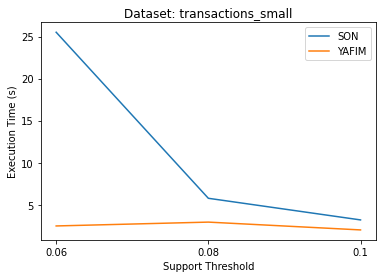

In [ ]:
plt.plot(support_list, son_t_small, label="SON")
plt.plot(support_list, yafim_t_small, label="YAFIM")

plt.title("Dataset: transactions_small")
plt.xlabel("Support Threshold")
plt.ylabel("Execution Time (s)")

plt.xticks(support_list, support_list)

plt.legend()

plt.show()

> Esecuzione di YAFIM e SON su 'transactions_medium'

In [ ]:
yafim_t_medium, son_t_medium = benchmark_yafim_son(transactions_medium, support_list)

Dataset with 23660 transactions & max length of transaction: 674

Support treshold: 0.1
Apply yafim
YAFIM result: [('WHITE HANGING HEART T-LIGHT HOLDER', 3177)]
yafim found 1 frequent itemsets in 3.140524613000025 seconds
Apply son with 2 chunk
SON result: [(('WHITE HANGING HEART T-LIGHT HOLDER',), 3177)]
son found 1 frequent itemsets in 5.600118246999955 seconds

Support treshold: 0.08
Apply yafim
YAFIM result: [('WHITE HANGING HEART T-LIGHT HOLDER', 3177), ('REGENCY CAKESTAND 3 TIER', 1953)]
yafim found 2 frequent itemsets in 3.6657899710000947 seconds
Apply son with 2 chunk
SON result: [(('REGENCY CAKESTAND 3 TIER',), 1953), (('WHITE HANGING HEART T-LIGHT HOLDER',), 3177)]
son found 2 frequent itemsets in 13.708112544000187 seconds

Support treshold: 0.06
Apply yafim
YAFIM result: [('WHITE HANGING HEART T-LIGHT HOLDER', 3177), ('STRAWBERRY CERAMIC TRINKET BOX', 1594), ('REGENCY CAKESTAND 3 TIER', 1953)]
yafim found 3 frequent itemsets in 3.4905546280001545 seconds
Apply son with 2 c

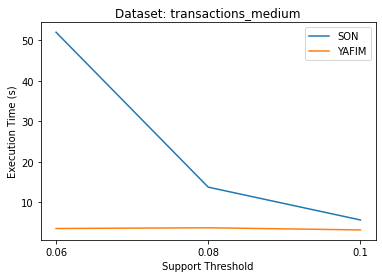

In [ ]:
plt.plot(support_list, son_t_medium, label="SON")
plt.plot(support_list, yafim_t_medium, label="YAFIM")

plt.title("Dataset: transactions_medium")
plt.xlabel("Support Threshold")
plt.ylabel("Execution Time (s)")

plt.xticks(support_list, support_list)

plt.legend()

plt.show()

> Esecuzione di YAFIM e SON su 'transactions_big'

In [ ]:
yafim_t_big, son_t_big = benchmark_yafim_son(transactions_big, support_list)

Dataset with 25761 transactions & max length of transaction: 674

Support treshold: 0.1
Apply yafim
YAFIM result: [('WHITE HANGING HEART T-LIGHT HOLDER', 3290)]
yafim found 1 frequent itemsets in 3.2283628369996222 seconds
Apply son with 2 chunk
SON result: [(('WHITE HANGING HEART T-LIGHT HOLDER',), 3290)]
son found 1 frequent itemsets in 5.353186272999665 seconds

Support treshold: 0.08
Apply yafim
YAFIM result: [('WHITE HANGING HEART T-LIGHT HOLDER', 3290), ('REGENCY CAKESTAND 3 TIER', 2160)]
yafim found 2 frequent itemsets in 3.518954565999593 seconds
Apply son with 2 chunk
SON result: [(('REGENCY CAKESTAND 3 TIER',), 2160), (('WHITE HANGING HEART T-LIGHT HOLDER',), 3290)]
son found 2 frequent itemsets in 12.568746780000765 seconds

Support treshold: 0.06
Apply yafim
YAFIM result: [('WHITE HANGING HEART T-LIGHT HOLDER', 3290), ('STRAWBERRY CERAMIC TRINKET BOX', 1705), ('REGENCY CAKESTAND 3 TIER', 2160)]
yafim found 3 frequent itemsets in 3.5935401550004826 seconds
Apply son with 2 c

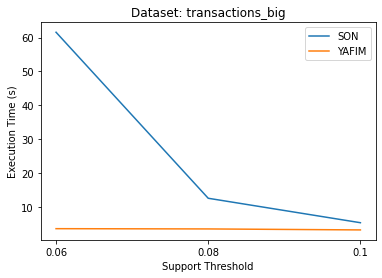

In [ ]:
plt.plot(support_list, son_t_big, label="SON")
plt.plot(support_list, yafim_t_big, label="YAFIM")

plt.title("Dataset: transactions_big")
plt.xlabel("Support Threshold")
plt.ylabel("Execution Time (s)")

plt.xticks(support_list, support_list)

plt.legend()

plt.show()

> Esecuzione di SON con differenti numeri di chunk creati

Creiamo una funzione **benchmark_son(dataset, support_list, num_partitions_1, num_partitions_2)** per eseguire su un dataset l'algoritmo di son sia in un dataset con 'num_partitions_1' chunk, che in un chunk con 'num_partitions_2'.
Inoltre sono eseguiti con tutti i possibili supporti in support_list

In [ ]:
def benchmark_son(dataset, support_list, num_partitions_1, num_partitions_2):

  son_1_times_list = []
  son_2_times_list = []
  max_len_itemsets = len(max(dataset, key=len))
  print(f"Dataset with {len(dataset)} transactions & max length of transaction: {max_len_itemsets}")

  for sup in support_list:

      print(f"\nSupport treshold: {sup}")
      print(f"Apply son with {num_partitions_1} chunk")
      start_time_son_1 = timeit.default_timer()
      result_son_1 = son(dataset, sup, num_partitions_1)
      end_time_son_1 = timeit.default_timer()
      print("SON result:", result_son_1)
      son_1_times_list.append(end_time_son_1 - start_time_son_1)
      print(f"son found {len(result_son_1)} frequent itemsets in {end_time_son_1 - start_time_son_1} seconds")
      
      print(f"Apply son with {num_partitions_2} chunk")
      start_time_son_2 = timeit.default_timer()
      result_son_2 = son(dataset, sup, num_partitions_2)
      end_time_son_2 = timeit.default_timer()
      print("SON result:", result_son_2)
      son_2_times_list.append(end_time_son_2 - start_time_son_2)
      print(f"son found {len(result_son_2)} frequent itemsets in {end_time_son_2 - start_time_son_2} seconds")
  
  return son_1_times_list, son_2_times_list

In [ ]:
support_list = [0.10, 0.08, 0.06]

In [ ]:
num_partitions_1 = 2
num_partitions_2 = 3
son_1, son_2 = benchmark_son(transactions_small, support_list, 2, 4)

Dataset with 2101 transactions & max length of transaction: 200

Support treshold: 0.1
Apply son with 2 chunk
SON result: [(('ROUND SNACK BOXES SET OF4 WOODLAND ',), 219)]
son found 1 frequent itemsets in 1.863017918999958 seconds
Apply son with 4 chunk
SON result: [(('ROUND SNACK BOXES SET OF4 WOODLAND ',), 219)]
son found 1 frequent itemsets in 142.0479785560001 seconds

Support treshold: 0.08
Apply son with 2 chunk
SON result: [(('RED TOADSTOOL LED NIGHT LIGHT',), 204), (('PACK OF 72 RETRO SPOT CAKE CASES',), 171), (('ROUND SNACK BOXES SET OF4 WOODLAND ',), 219), (('REGENCY CAKESTAND 3 TIER',), 207), (('WOODLAND CHARLOTTE BAG',), 173)]
son found 5 frequent itemsets in 7.749298856999758 seconds
Apply son with 4 chunk
SON result: [(('PACK OF 72 RETRO SPOT CAKE CASES',), 171), (('RED TOADSTOOL LED NIGHT LIGHT',), 204), (('ROUND SNACK BOXES SET OF4 WOODLAND ',), 219), (('REGENCY CAKESTAND 3 TIER',), 207), (('WOODLAND CHARLOTTE BAG',), 173)]
son found 5 frequent itemsets in 294.664592927

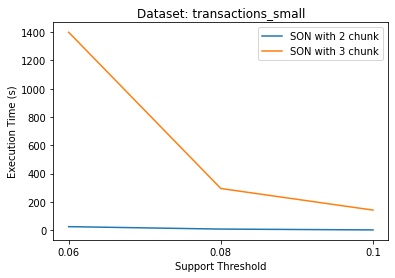

In [ ]:
plt.plot(support_list, son_1, label=f"SON with {num_partitions_1} chunk")
plt.plot(support_list, son_2, label=f"SON with {num_partitions_2} chunk")

plt.title("Dataset: transactions_small")
plt.xlabel("Support Threshold")
plt.ylabel("Execution Time (s)")

plt.xticks(support_list, support_list)

plt.legend()

plt.show()

Sono stati effettuati dei test con dataset di varie dimensioni e con differenti supporti. 

Dai grafici possiamo notare: 

- Su uno stesso dataset le prestazioni di entrambi gli algoritmi diminuiscono al diminuire del supporto. 

- Le prestazioni di SON al diminuire del supporto calano più velocemente delle prestazioni di YAFIM, questo perché in SON l’applicazione dell’algoritmo Apriori ad ogni chunk del dataset con supporto ridotto provoca una generazione di molti candidati. 

- Le prestazioni di SON calano all’aumentare del numero di chunk in cui si partiziona il dataset 

- YAFIM rispetto a SON rimane più costante all’aumentare del solo numero di transazioni. 

In [ ]:
# Stop SparkContext
sc.stop()